In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys, os, time, math
import functools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn import decomposition
from sklearn import datasets

from datasets import DataGenerator, DataGeneratorSymmetric, generate_multiv_gauss
from datasets import DataGeneratorStatic, DataGeneratorSymmetricStatic
from vae import  VAE_vanilla, VAE_known
from logger import Logger
from IPython import display

# VAE toy model

## Create dataset

In [4]:
DATA_DIM = 100
LATENT_DIM = 2
DATASET_SIZE = 1000
BATCH_SIZE = 32

In [5]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=0.01)
dataset_sym = DataGeneratorSymmetricStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)
data_loader_sym = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

## Training of the model 

In [6]:
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM)
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-4, amsgrad=True)
epochs = 1000

logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

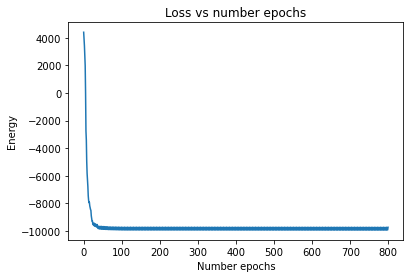

In [7]:
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [22]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [23]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [24]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

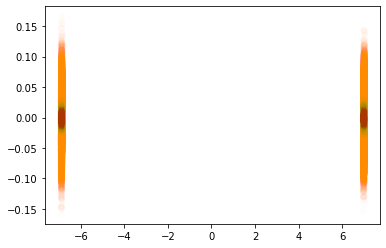

In [32]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [30]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [33]:
print(res)

tensor([1.0000, 1.0000])


As we can see centroids predicted very precisely

## Eperiments

### N=100, M=1000, $\alpha$=10, std=1

In [35]:
DATA_DIM = 100
DATASET_SIZE = 1000
BATCH_SIZE = 32
STD = 1

In [36]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [37]:
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM)
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-4, amsgrad=True)
epochs = 200

logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

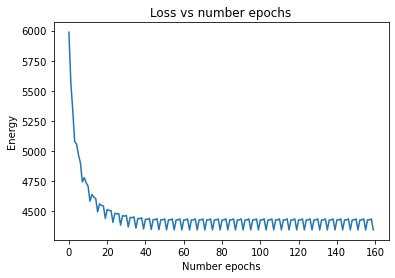

In [38]:
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [39]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [40]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [41]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

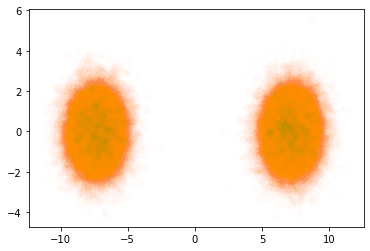

In [52]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

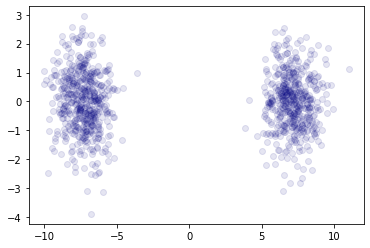

In [53]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

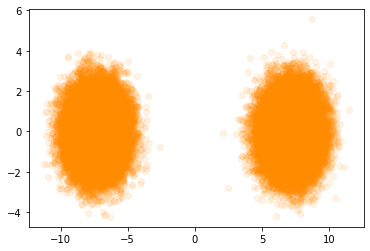

In [54]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [48]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [49]:
print(res)

tensor([-0.0211, -0.0145])


Cosine similarity not very big, but projection on the two most significant direction very similar

### N=100, M=1000, $\alpha$=10, std=1 longer trained with fixed std

In [75]:
DATA_DIM = 100
DATASET_SIZE = 1000
BATCH_SIZE = 32
STD = 1

In [76]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [78]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

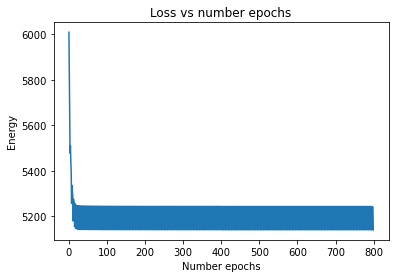

In [88]:
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-5, amsgrad=True)
epochs = 500
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [89]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [90]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [91]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

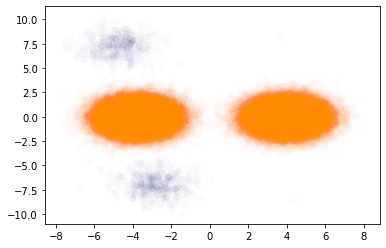

In [92]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

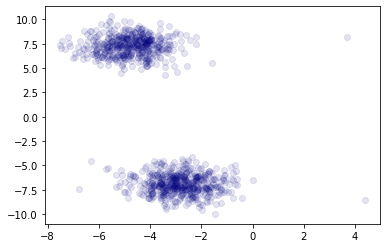

In [93]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

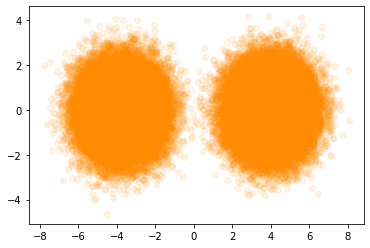

In [94]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [95]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [96]:
print(res)

tensor([0.7053, 0.2670])


Cosine similarity better than prev one, but projection on the two most significant direction not very similar

### N=100, M=5000, $\alpha$=50, std=1

In [98]:
DATA_DIM = 100
DATASET_SIZE = 5000
BATCH_SIZE = 32
STD = 1

In [99]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [100]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

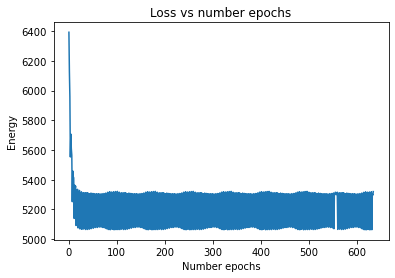

In [111]:
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-5, amsgrad=True)
epochs = 10
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [112]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [113]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [114]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

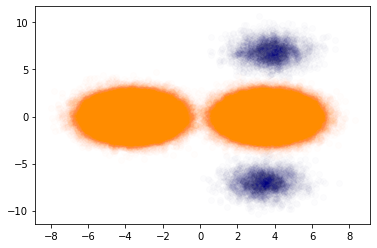

In [115]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

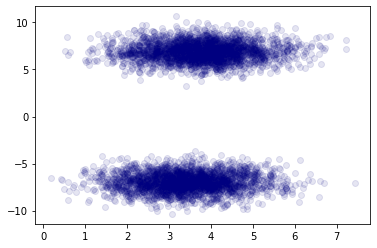

In [116]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

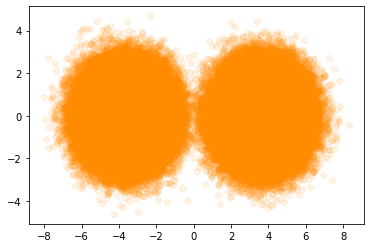

In [117]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [118]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [119]:
print(res)

tensor([0.0457, 0.7290])


Cosine similarity not very big, but projection on the two most significant direction very similar

### N=100, M=100, $\alpha$=1, std=1

In [120]:
DATA_DIM = 100
DATASET_SIZE = 100
BATCH_SIZE = 32
STD = 1

In [121]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [122]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

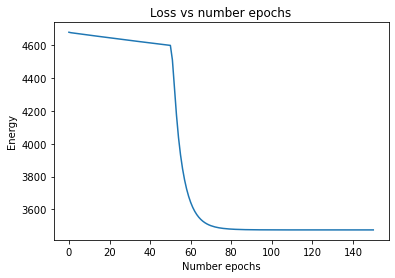

In [124]:
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-5, amsgrad=True)
epochs = 1000
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [125]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [126]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [127]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

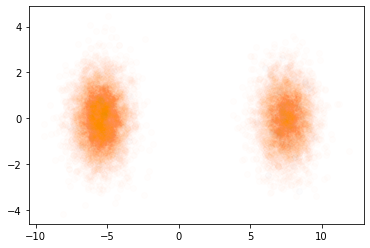

In [128]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

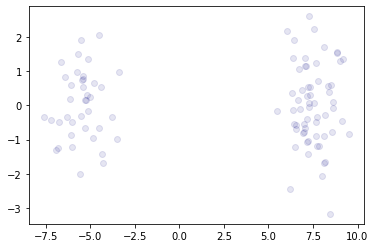

In [129]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

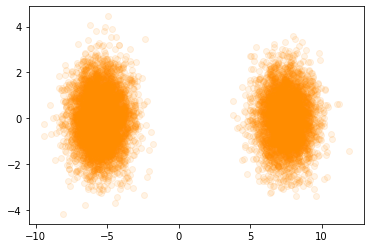

In [130]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [131]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [132]:
print(res)

tensor([0.9879, 0.9911])


Cosine similarity is very good

### N=100, M=300, $\alpha$=3, std=1

In [138]:
DATA_DIM = 100
DATASET_SIZE = 300
BATCH_SIZE = 32
STD = 1

In [139]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [140]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

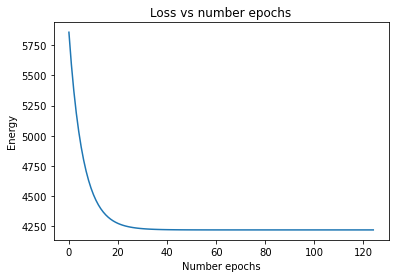

In [141]:
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-5, amsgrad=True)
epochs = 500
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [142]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [143]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [144]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

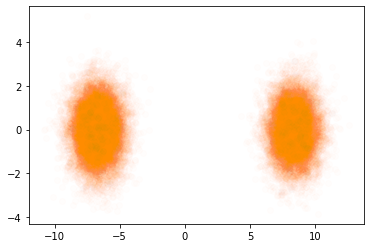

In [145]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

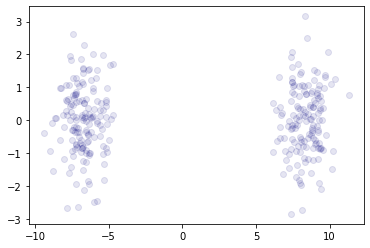

In [146]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

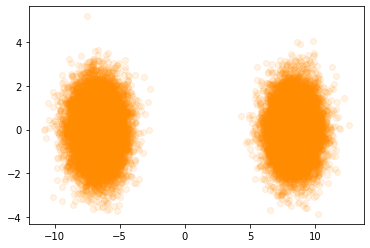

In [147]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [148]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [149]:
print(res)

tensor([0.9971, 0.9973])


Cosine similarity is very good

### N=100, M=600, $\alpha$=6, std=1

In [150]:
DATA_DIM = 100
DATASET_SIZE = 600
BATCH_SIZE = 32
STD = 1

In [151]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [152]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

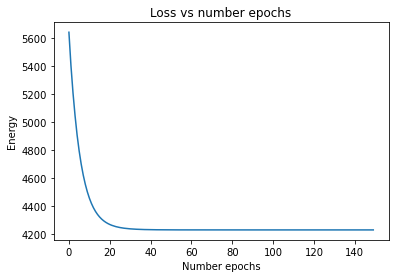

In [153]:
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-5, amsgrad=True)
epochs = 300
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [154]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [155]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [156]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

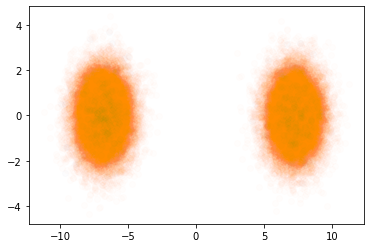

In [157]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

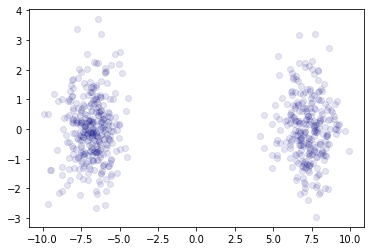

In [158]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

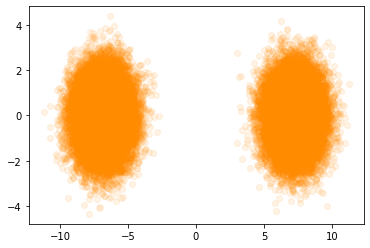

In [159]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [160]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [161]:
print(res)

tensor([0.9985, 0.9977])


Cosine similarity is very good

### N=100, M=900, $\alpha$=9, std=1

In [162]:
DATA_DIM = 100
DATASET_SIZE = 900
BATCH_SIZE = 32
STD = 1

In [163]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [164]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

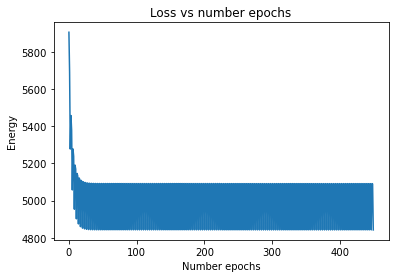

In [184]:
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-4, amsgrad=True)
epochs = 100
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [185]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [186]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [187]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

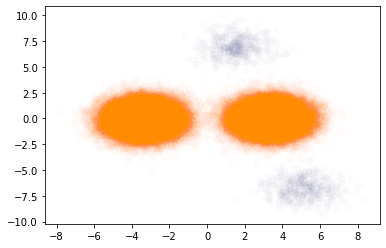

In [188]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

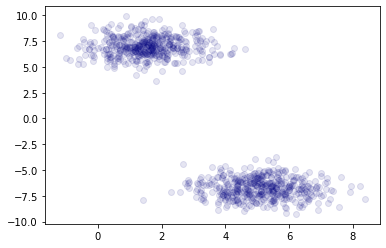

In [189]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

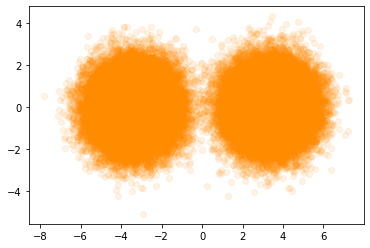

In [190]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [191]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [192]:
print(res)

tensor([0.1493, 0.7757])


Cosine similarity is not very good

### N=100, M=50, $\alpha$=0.5, std=1

In [241]:
DATA_DIM = 100
DATASET_SIZE = 50
BATCH_SIZE = 32
STD = 1

In [242]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [243]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

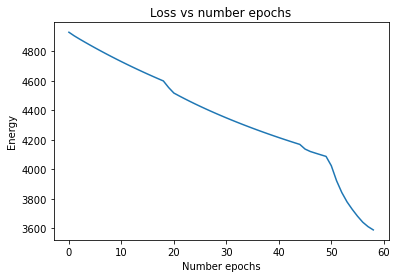

In [ ]:
vae_model.compile(torch.optim.Adam, lr=3e-3, weight_decay=2e-4, amsgrad=True)
epochs = 1000
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [245]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [246]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [247]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

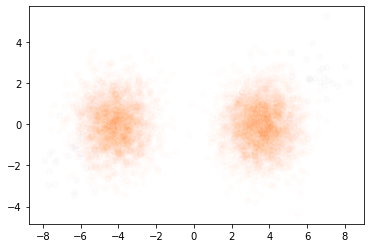

In [248]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

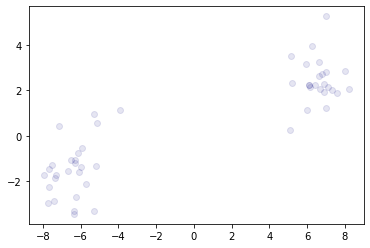

In [249]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

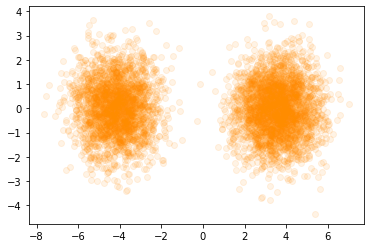

In [250]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [251]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [252]:
print(res)

tensor([-0.0749, -0.2332])


Cosine similarity is not very good

### N=100, M=900, $\alpha$=9, std=0.5

In [209]:
DATA_DIM = 100
DATASET_SIZE = 900
BATCH_SIZE = 32
STD = 0.5

In [210]:
dataset = DataGeneratorStatic(data_dim=DATA_DIM, data_size=DATASET_SIZE, std=STD)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)

In [211]:
std_grad = True
if STD==1: std_grad=False
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM, std_grad=std_grad)


logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

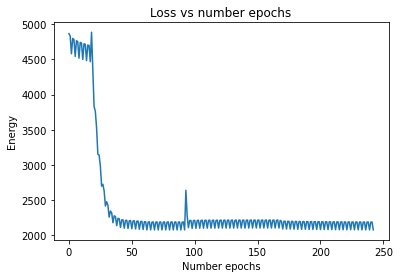

In [231]:
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-4, amsgrad=True)
epochs = 100
for epoch in range(epochs):
    for data_batch in data_loader:
        loss = vae_model.loss(data_batch)
        vae_model.step(loss)
        display.clear_output(wait=True)
        logger_vae_known.update("loss", loss)

In [232]:
real_data = dataset.data
real_data = [x.numpy() for x in real_data]
real_data = np.array(real_data)

p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(len(real_data)) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z = torch.zeros(len(real_data), 2)
z[:, 0] += 1 - z_samples
z[:, 1] += z_samples
generation_dists = vae_model.decoder(z)
generated_data = generation_dists.sample() 

for i in range(100):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [233]:
real_data = real_data
generated_data = generated_data.numpy()

data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [234]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

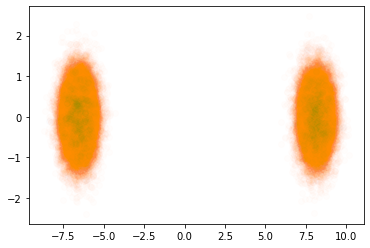

In [235]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.01)

plt.show()

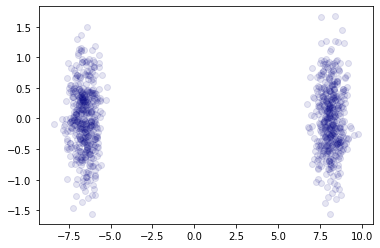

In [236]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

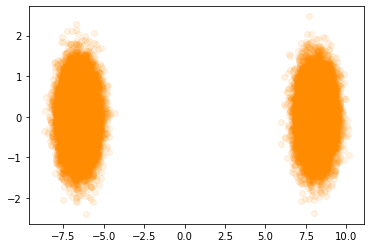

In [237]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

### Let's compute cosine similarity between true and predicted centroids

In [238]:
predicted_centroids = vae_model.decoder_fc.state_dict()['weight'].T 
cos = nn.CosineSimilarity(dim=1)
res = cos(dataset.v, predicted_centroids)

In [239]:
print(res)

tensor([-0.1479, -0.1468])


Cosine similarity is not very good

# Online learning datasets

In [6]:
MAX_ITER = 10000

In [7]:
dataset = DataGenerator(data_dim=DATA_DIM, max_iter=MAX_ITER)
dataset_sym = DataGeneratorSymmetric(data_dim=DATA_DIM, max_iter=MAX_ITER)

In [8]:
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)
data_loader_sym = DataLoader(dataset_sym, batch_size=BATCH_SIZE, num_workers=2)

# VAE vanilla training

In [6]:
vae_model = VAE_vanilla(data_dim=DATA_DIM,latent_dim=LATENT_DIM)
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-6, amsgrad=True)

logger_vanilla = Logger(name="VAE vanilla")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vanilla.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

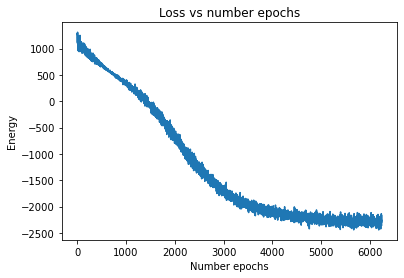

In [7]:
for data_batch in data_loader:
    loss = vae_vanilla_loss(data_batch, vae_model)
    vae_model.step(loss)
    display.clear_output(wait=True)
    logger_vanilla.update("loss", loss)

In [8]:
data_iter = iter(data_loader)
max_iter = 4
real_data = next(data_iter)
for i in range(max_iter):
    new_data = next(data_iter)
    real_data = torch.cat((real_data, new_data))

In [9]:
mean = torch.zeros(LATENT_DIM)
cov = torch.eye(LATENT_DIM)
max_iter = 1
z_samples = generate_multiv_gauss(real_data.shape[0]//max_iter, mean, cov)
generation_dists = vae_model.decoder(z_samples)
generated_data = generation_dists.sample() 

In [10]:
for i in range(max_iter):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [11]:
real_data = real_data.numpy()
generated_data = generated_data.numpy()

In [12]:
data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [13]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

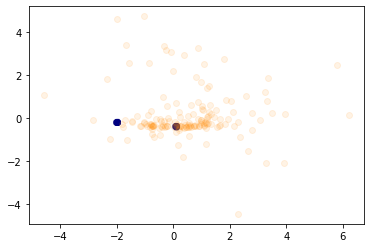

In [14]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.1)

plt.show()

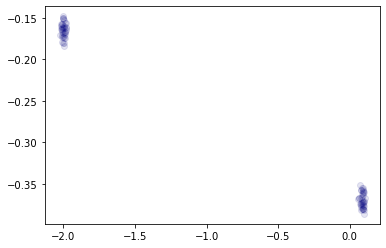

In [15]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

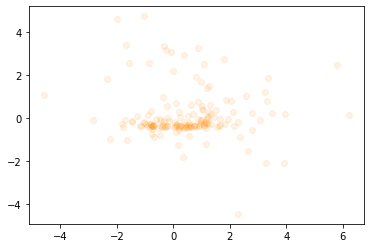

In [16]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

# VAE everything known

In [104]:
DATA_DIM = DATA_DIM
LATENT_DIM = 1
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM)
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-4, amsgrad=True)

logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

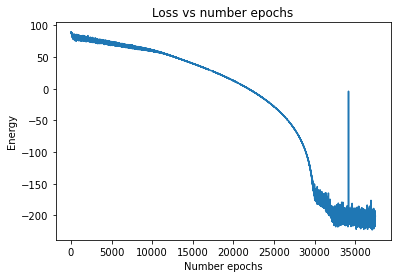

In [134]:
for data_batch in data_loader_sym:
    loss = vae_known_loss(data_batch, vae_model)
    vae_model.step(loss)
    display.clear_output(wait=True)
    logger_vae_known.update("loss", loss)

In [135]:
data_iter = iter(data_loader_sym)
max_iter = 4
real_data = next(data_iter)
for i in range(max_iter):
    new_data = next(data_iter)
    real_data = torch.cat((real_data, new_data))

In [136]:
p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(real_data.shape[0], 1) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z_samples[z_samples==0] = -1
generation_dists = vae_model.decoder(z_samples)
generated_data = generation_dists.sample() 

In [137]:
for i in range(max_iter):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [138]:
real_data = real_data.numpy()
generated_data = generated_data.numpy()

In [139]:
data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [140]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

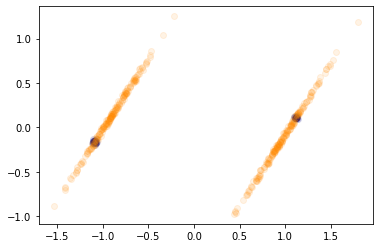

In [141]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.1)

plt.show()

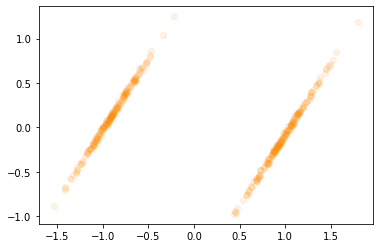

In [142]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

In [153]:
vae_model.decoder_fc.state_dict()

OrderedDict([('weight',
              tensor([[-0.4016],
                      [-0.2145],
                      [ 0.0162],
                      [-0.7733],
                      [ 0.3182]]))])

In [154]:
dataset_sym.v

tensor([ 0.6983,  0.2146, -0.0166,  0.7723, -0.3181])

In [155]:
vae_model.std

Parameter containing:
tensor([0.3978, 0.0098, 0.0100, 0.0097, 0.0101], requires_grad=True)